# Preparing Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('All_GPUs.csv')

data['Resolution_W'], data['Resolution_H'] = data['Resolution_WxH'].str.split('x').str
data['Core_Speed_MHz'] = data['Core_Speed'].str.replace(' MHz', '')
data['Memory_Speed_MHz'] = data['Memory_Speed'].str.replace(' MHz', '')
data['Max_Power_Watts'] = data['Max_Power'].str.replace(' Watts', '')
data['Release_Price_Dollars'] = data['Release_Price'].str.replace('$', '')
data['Memory_MB'] = data['Memory'].str.replace(' MB', '')
data['Memory_Bus_Bit'] = data['Memory_Bus'].str.replace(' Bit', '')
data['Memory_Bandwidth_GB_Sec'] = data['Memory_Bandwidth'].str.replace('GB/sec', '')

all_features = [
    "Resolution_W",
    "Resolution_H",
    "Core_Speed_MHz",
    "Memory_Speed_MHz",
    "Max_Power_Watts",
    "Release_Price_Dollars",
    "Memory_MB",
    "Memory_Bus_Bit",
    "Memory_Bandwidth_GB_Sec"
]

data = data[all_features].dropna()

for col in data.columns:
    data = data[pd.to_numeric(data[col], errors='coerce').notnull()]
    
data = data.dropna().drop_duplicates().astype('float').astype('int').reset_index(drop=True)

# Generating Nominal Features

### Core Speed

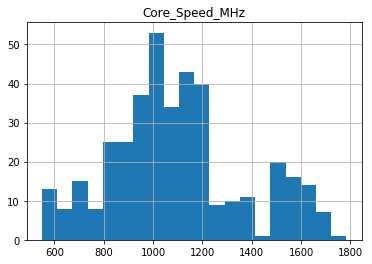

In [2]:
data.hist(column='Core_Speed_MHz', bins=20)
plt.show()

In [3]:
core_speed_bounds = [0, 780, 1050, 1450, 1800]  # we choose that by glance
core_speed_categories = []
for start, end in zip(core_speed_bounds, core_speed_bounds[1:]):
    indices = (data['Core_Speed_MHz'] >= start) & (data['Core_Speed_MHz'] < end)
    core_speed_categories.append(list(data[indices].index))  # indices for all samples of the category

### Memory Bandwidth

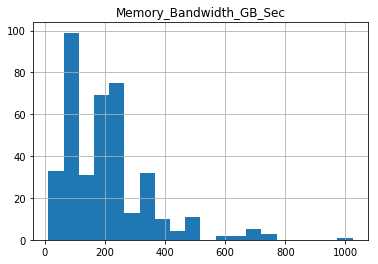

In [4]:
data.hist(column='Memory_Bandwidth_GB_Sec', bins=20)
plt.show()

In [5]:
mem_bandwidth_bounds = [0, 140, 290, 550, 1100]  # we choose that by glance
mem_band_categories = []
for start, end in zip(mem_bandwidth_bounds, mem_bandwidth_bounds[1:]):
    indices = (data['Memory_Bandwidth_GB_Sec'] >= start) & (data['Memory_Bandwidth_GB_Sec'] < end)
    mem_band_categories.append(list(data[indices].index))  # indices for all samples of the category

### Taxonomy

In [6]:
# We make taxon partitioning by 4 groups
taxon_bounds = [0, len(data)//4, len(data)//4*2, len(data)//4*3, len(data)]
taxon_categories = [
    list(range(start, end))
    for (start, end) in zip(taxon_bounds, taxon_bounds[1:])
]

# Building Conditional Frequency Tables

In [7]:
from tabulate import tabulate

# C – Core_Speed_MHz feature
# Number of samples in each partition
c_samples = np.array([
    (
        [
            len(set(taxon) & set(category))
            for category in core_speed_categories
        ] + [len(taxon)]
    )
    for taxon in taxon_categories
] + [[len(category) for category in core_speed_categories] + [len(data)]])

c_rel_freq = c_samples / np.sum(c_samples[:-1, :-1])  # Relational Frequency Table (C->T)
# Can be visualised, but we skip this part to make the report cleaner
# print('Relational Frequency Table (C->T)')
# print(tabulate(c_rel_freq, ['C_1', 'C_2', 'C_3', 'C_4', 'Total'], tablefmt='fancy_grid', floatfmt='.3f'))

In [8]:
# M – Memory_Bandwidth_GB_Sec feature
# Number of samples in each partition
m_samples = np.array([
    (
        [
            len(set(taxon) & set(category))
            for category in mem_band_categories
        ] + [len(taxon)]
    )
    for taxon in taxon_categories
] + [[len(category) for category in mem_band_categories] + [len(data)]])

m_rel_freq = m_samples / np.sum(m_samples[:-1, :-1])  # Relational Frequency Table (M->T)
# Can be visualised, but we skip this part to make the report cleaner
# print('Relational Frequency Table (M->T)')
# print(tabulate(m_rel_freq, ['M_1', 'M_2', 'M_3', 'M_4', 'Total'], tablefmt='fancy_grid', floatfmt='.3f'))

In [9]:
LEFT_HEADERS = np.array(['T_1', 'T_2', 'T_3', 'T_4']).reshape(4, 1)
c_cond_freq = c_samples[:-1,:-1] / np.sum(c_samples[:-1,:-1], axis=0)
print('Conditional Frequency Table (C->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, c_cond_freq), axis=1),
    headers=['', 'C_1', 'C_2', 'C_3', 'C_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))

Conditional Frequency Table (C->T)
╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   C_1 │   C_2 │   C_3 │   C_4 │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ T_1 │ 0.093 │ 0.413 │ 0.233 │ 0.000 │
├─────┼───────┼───────┼───────┼───────┤
│ T_2 │ 0.372 │ 0.231 │ 0.260 │ 0.172 │
├─────┼───────┼───────┼───────┼───────┤
│ T_3 │ 0.256 │ 0.112 │ 0.151 │ 0.828 │
├─────┼───────┼───────┼───────┼───────┤
│ T_4 │ 0.279 │ 0.245 │ 0.356 │ 0.000 │
╘═════╧═══════╧═══════╧═══════╧═══════╛


Here we can see that C4 (high core speed) implies with high (83%) probability taxon T3, with some much lower probability (17%) – taxon T2 and with zero probability – taxons T1 and T4.

T1 is also quite improbable (with probability of 9%) to be for any sample from C1.

In [10]:
m_cond_freq = m_samples[:-1, :-1] / np.sum(m_samples[:-1,:-1], axis=0)
print('Conditional Frequency Table (M->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, m_cond_freq), axis=1),
    ['', 'M_1', 'M_2', 'M_3', 'M_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))

Conditional Frequency Table (M->T)
╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   M_1 │   M_2 │   M_3 │   M_4 │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ T_1 │ 0.100 │ 0.300 │ 0.404 │ 0.615 │
├─────┼───────┼───────┼───────┼───────┤
│ T_2 │ 0.340 │ 0.188 │ 0.211 │ 0.154 │
├─────┼───────┼───────┼───────┼───────┤
│ T_3 │ 0.233 │ 0.324 │ 0.123 │ 0.000 │
├─────┼───────┼───────┼───────┼───────┤
│ T_4 │ 0.327 │ 0.188 │ 0.263 │ 0.231 │
╘═════╧═══════╧═══════╧═══════╧═══════╛


Here we can see that M4 (high memory bandwidth) implies with 62% probability taxon T1, which is a high enough probability.

It is also seen that M4 with 100% probability guarantees anything but T3.

Besides, with rather high probability (90%) GPUs with the lowers memory bandwidth will not be in T1.


# Building Quetelet Index Tables

In [11]:
c_indep_freq = c_rel_freq[:,4].reshape(5, 1) @ c_rel_freq[4,:].reshape(1, 5)
c_quetelet_index = c_rel_freq[0:4,0:4] / c_indep_freq[0:4,0:4] - 1
print('Quetelet Index Table (C->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, c_quetelet_index), axis=1),
    ['', 'C_1', 'C_2', 'C_3', 'C_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))

Quetelet Index Table (C->T)
╒═════╤════════╤════════╤════════╤════════╕
│     │    C_1 │    C_2 │    C_3 │    C_4 │
╞═════╪════════╪════════╪════════╪════════╡
│ T_1 │ -0.626 │  0.659 │ -0.064 │ -1.000 │
├─────┼────────┼────────┼────────┼────────┤
│ T_2 │  0.496 │ -0.072 │  0.046 │ -0.307 │
├─────┼────────┼────────┼────────┼────────┤
│ T_3 │  0.029 │ -0.550 │ -0.394 │  2.327 │
├─────┼────────┼────────┼────────┼────────┤
│ T_4 │  0.099 │ -0.036 │  0.403 │ -1.000 │
╘═════╧════════╧════════╧════════╧════════╛


Here we can see that after choosing sample from C4 or T3, with much higher probability it will be a sample from T3 and C4 accordingly.
Probability of C4 and T1,T2,T4 are accordingly lowered.

Probability of simultaneously choosing sample from T1 and C1 is also lowered.

In [12]:
m_indep_freq = m_rel_freq[:,4].reshape(5, 1) @ m_rel_freq[4,:].reshape(1, 5)
m_quetelet_index = m_rel_freq[0:4,0:4] / m_indep_freq[0:4,0:4] - 1
print('Quetelet Index Table (M->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, m_quetelet_index), axis=1),
    ['', 'M_1', 'M_2', 'M_3', 'M_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))

Quetelet Index Table (M->T)
╒═════╤════════╤════════╤════════╤════════╕
│     │    M_1 │    M_2 │    M_3 │    M_4 │
╞═════╪════════╪════════╪════════╪════════╡
│ T_1 │ -0.598 │  0.206 │  0.622 │  1.474 │
├─────┼────────┼────────┼────────┼────────┤
│ T_2 │  0.367 │ -0.243 │ -0.154 │ -0.381 │
├─────┼────────┼────────┼────────┼────────┤
│ T_3 │ -0.062 │  0.301 │ -0.506 │ -1.000 │
├─────┼────────┼────────┼────────┼────────┤
│ T_4 │  0.287 │ -0.258 │  0.037 │ -0.091 │
╘═════╧════════╧════════╧════════╧════════╛


Probability of choosing sample from both T1 and M4 is much higher than normal.

At the same time simultaneous inclusions in (T1, M1) and (T3, M3) is lower than average.

Being simultaneously in both T3 and M4 is impossible (0% probability).

# Computing X2 values

In [13]:
c_pearsson = ((c_rel_freq - c_indep_freq)**2) / c_indep_freq
print('X matrix (C->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, c_pearsson[:-1,:-1]), axis=1),
    ['', 'C_1', 'C_2', 'C_3', 'C_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))
print('X^2 = sum(matrix) = {}'.format(c_pearsson.sum()))

X matrix (C->T)
╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   C_1 │   C_2 │   C_3 │   C_4 │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ T_1 │ 0.011 │ 0.040 │ 0.000 │ 0.037 │
├─────┼───────┼───────┼───────┼───────┤
│ T_2 │ 0.007 │ 0.000 │ 0.000 │ 0.003 │
├─────┼───────┼───────┼───────┼───────┤
│ T_3 │ 0.000 │ 0.028 │ 0.014 │ 0.200 │
├─────┼───────┼───────┼───────┼───────┤
│ T_4 │ 0.000 │ 0.000 │ 0.015 │ 0.038 │
╘═════╧═══════╧═══════╧═══════╧═══════╛
X^2 = sum(matrix) = 0.3946423078510352


Item (C4 -> T3) with value 0.2 is the most deviated from the independence.

In [14]:
m_pearsson = ((m_rel_freq - m_indep_freq)**2) / m_indep_freq
print('X matrix (M->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, m_pearsson[:-1,:-1]), axis=1),
    ['', 'M_1', 'M_2', 'M_3', 'M_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))
print('X^2 = sum(matrix) = {}'.format(m_pearsson.sum()))

X matrix (M->T)
╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   M_1 │   M_2 │   M_3 │   M_4 │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ T_1 │ 0.034 │ 0.005 │ 0.014 │ 0.018 │
├─────┼───────┼───────┼───────┼───────┤
│ T_2 │ 0.013 │ 0.006 │ 0.001 │ 0.001 │
├─────┼───────┼───────┼───────┼───────┤
│ T_3 │ 0.000 │ 0.010 │ 0.009 │ 0.008 │
├─────┼───────┼───────┼───────┼───────┤
│ T_4 │ 0.008 │ 0.007 │ 0.000 │ 0.000 │
╘═════╧═══════╧═══════╧═══════╧═══════╛
X^2 = sum(matrix) = 0.13559625276199913


Item (M1 -> T1) with value 0.034 is the most deviated from the independence, which is not that much, so the whole table shows more or less independent values

# Computing Average Quatelet Indices

In [15]:
c_average_quetelet = c_rel_freq[:-1,:-1] * c_quetelet_index
print('Averate Quetelet Index matrix (C->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, c_average_quetelet), axis=1),
    ['', 'C_1', 'C_2', 'C_3', 'C_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))
print('Q = sum(matrix) = {}'.format(c_average_quetelet.sum()))

Averate Quetelet Index matrix (C->T)
╒═════╤════════╤════════╤════════╤════════╕
│     │    C_1 │    C_2 │    C_3 │    C_4 │
╞═════╪════════╪════════╪════════╪════════╡
│ T_1 │ -0.006 │  0.100 │ -0.006 │ -0.000 │
├─────┼────────┼────────┼────────┼────────┤
│ T_2 │  0.020 │ -0.006 │  0.005 │ -0.008 │
├─────┼────────┼────────┼────────┼────────┤
│ T_3 │  0.001 │ -0.023 │ -0.022 │  0.286 │
├─────┼────────┼────────┼────────┼────────┤
│ T_4 │  0.003 │ -0.003 │  0.054 │ -0.000 │
╘═════╧════════╧════════╧════════╧════════╛
Q = sum(matrix) = 0.39464230785103516


In [16]:
m_average_quetelet = m_rel_freq[:-1,:-1] * m_quetelet_index
print('Averate Quetelet Index matrix (M->T)')
print(tabulate(
    np.concatenate((LEFT_HEADERS, m_average_quetelet), axis=1),
    ['M_1', 'M_2', 'M_3', 'M_4'],
    tablefmt='fancy_grid', floatfmt='.3f'
))
print('Q = sum(matrix) = {}'.format(m_average_quetelet.sum()))

Averate Quetelet Index matrix (M->T)
╒═════╤════════╤════════╤════════╤════════╕
│     │    M_1 │    M_2 │    M_3 │    M_4 │
╞═════╪════════╪════════╪════════╪════════╡
│ T_1 │ -0.023 │  0.027 │  0.037 │  0.030 │
├─────┼────────┼────────┼────────┼────────┤
│ T_2 │  0.048 │ -0.020 │ -0.005 │ -0.002 │
├─────┼────────┼────────┼────────┼────────┤
│ T_3 │ -0.006 │  0.042 │ -0.009 │ -0.000 │
├─────┼────────┼────────┼────────┼────────┤
│ T_4 │  0.036 │ -0.021 │  0.001 │ -0.001 │
╘═════╧════════╧════════╧════════╧════════╛
Q = sum(matrix) = 0.1355962527619991


# Determining number of samples

Number of degrees of freedom for contingency table is $df=(4-1)*(4-1)=9$.

For this, at the 95% probability chi-squared value is less than 16.92.

At the 99% probability chi-squared value is less than 21.67

### C -> T

For $X^2=0.39464$ and $X^2*N > 16.92$ $\Rightarrow N > \frac{16.92}{0.39464} = 42.87$.

That means that for any $N\geq 43$ we can reject the hypothesis of statistical independence at 95% confidence level. For any $N \leq 42$ the hypothesis should be accepted.

At the 99% probability chi-squared value is less than 21.67.
For $X^2=0.39464$ and $X^2*N > 21.67$ $\Rightarrow N > \frac{21.67}{0.39464} = 54.91$.

That means that for any $N\geq 55$ we can reject the hypothesis of statistical independence at 99% confidence level. For any $N \leq 54$ the hypothesis should be accepted.

### M -> T

For $X^2=0.135596$ and $X^2*N > 16.92$ $\Rightarrow N > \frac{16.92}{0.135596} = 124.78$.

That means that for any $N\geq 125$ we can reject the hypothesis of statistical independence at 95% confidence level. For any $N \leq 124$ the hypothesis should be accepted.

At the 99% probability chi-squared value is less than 21.67.
For $X^2=0.135596$ and $X^2*N > 21.67$ $\Rightarrow N > \frac{21.67}{0.135596} = 159.81$.

That means that for any $N\geq 160$ we can reject the hypothesis of statistical independence at 99% confidence level. For any $N \leq 159$ the hypothesis should be accepted.

# Conclusion

So it can be seen that C partition (core speed) is much better associated with T partition than M partition (memory bandwidth).

There are a lot more items in C partition which are more deviant from statistical independence than in M partition,
and in average C partition is more dependent on T.

According to independence critetion, M partition required more samples to be rejected as statistically independent, which makes it less believeable to be associated with T.